In [4]:
import numpy as np
import json
import itertools
import spglib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
spglib.get_symmetry_from_database(10)

{'rotations': array([[[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  1]],
 
        [[-1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0, -1]],
 
        [[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  1]],
 
        [[-1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0, -1]]], dtype=int32),
 'translations': array([[0. , 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0.5, 0.5],
        [0. , 0.5, 0.5]])}

In [6]:
def write_group(f, members, name):
    # tiling code needs to be updated for more than 2D
    result = {'name': name, 'size': len(members), 'members': []}
    
    has_identity = False
    for m in members:
        # skip extra identities
        if np.allclose(np.eye(m.shape[0]), m):
            if not has_identity:
                has_identity = True
            else:
                continue
        if not has_identity:
            raise ValueError('Must start with identity')
        i = np.linalg.inv(m)
        # tiling meaning inner Ndim x Ndim is diag only and last column is non-zero
        # TODO: which one?
        diag = np.isclose(np.sum(m[:-1, :-1]**2), np.trace(m[:-1, :-1]**2))
        #diag = np.allclose(np.diag(m), np.ones(m.shape[0]))
        tiling = bool(not np.isclose(np.sum(m[:-1,-1]**2), 0) and diag)
        result['members'].append({'g': list(np.round(m.flatten(), 8)), 'i': list(np.round(i.flatten(), 8)), 't': tiling})
    # sort them - identity first and tiling last    
    result['members'].sort(
        key = lambda m: int(m['t']))
    json.dump(result, f, indent=True)
    print('Wrote group with', len(members), 'members and', sum([m['t'] for m in result['members']]), 'tilings')
    
def cgroup_2d(n):
    thetas = np.linspace(0, 2 * np.pi, n + 1)[:-1]
    r = []
    for t in thetas:
        print(t)
        s, c = np.sin(t), np.cos(t)
        r.append(np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]]))
    return r
def sgroup_2d(n):
    thetas = np.arange(0, n) / n
    r = [np.eye(3)]
    for t in thetas:
        s, c = np.sin(2 * np.pi * t), np.cos(2 * np.pi * t)
        r.append(np.array([[c, s, 0], [s, -c, 0], [0, 0, 1]]))
    return r

def trans_2d(theta):
    v = [np.eye(3) for _ in range(9)]
    a = [np.cos(theta), 3 * np.sin(theta)]
    b = [3, 0]
    for i in range(3):
        for j in range(3):
            v[i * 3 + j][0, 2] = (i - 1) * a[0] + (j - 1) * b[0]
            v[i * 3 + j][1, 2] = (i - 1) * a[1] + (j - 1) * b[1]
    # put identity at beginning
    del v[1 * 3 + 1]
    v.insert(0, np.eye(3))
    return v

def in_group(n, r):
    for ri in r:
        if np.allclose(n, ri):
            return True
    return False

def outer(g1, g2, remove_dups = True):
    r = []
    for i in g1:
        for j in g2:
            if not remove_dups or not in_group(i @ j, r):
                r.append(i @ j)
            if not remove_dups or not in_group(j @ i, r):
                r.append(j @ i)
    return r

def is_group(g, check_closed=True):
    r = []
    for i in g:
        gi = np.linalg.inv(i)
        iexist = False
        for j in g:
            if np.allclose(gi, j):
                iexist = True
                break
        if not iexist:
            return False
    if not check_closed:
        return True
    for i in g:
        for j in g:
            k = i @ j
            iexist = False
            for l in g:
                if np.allclose(l, k):
                    iexist = True
                    break
            if not iexist:
                return False
    return True

In [7]:
def str2mat(s):
    rows = []
    N = len(s.split(','))
    env = {'x': np.array([1,0]), 'y': np.array([0,1])}
    fake_env = {'x': 0, 'y': 0}
    for si in s.split(','):
        r = [0] * N
        l = {}
        # use fake ones to get translation
        exec('f = ' + si.strip(), fake_env, l)
        exec('o = ' + si.strip(),env, l)
        # remove trans and add
        rows.append(np.append(l['o'] - l['f'], l['f']))        
    rows.append(np.array([0,0,1]))
    return np.vstack(rows)
            
str2mat('x/6 - y/6, y + 1/2')

array([[ 0.16666667, -0.16666667,  0.        ],
       [ 0.        ,  1.        ,  0.5       ],
       [ 0.        ,  0.        ,  1.        ]])

In [8]:
cgroup_2d(2)[1] @  sgroup_2d(1)[1]

0.0
3.141592653589793


array([[-1.0000000e+00,  1.2246468e-16,  0.0000000e+00],
       [ 1.2246468e-16,  1.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [10]:
#TODO: make it so each input element matters
projectors = {             
    'square': 
    np.array([
        [1/4, 1/4, 1/4, 1/4], 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1/4, 1/4, 1/4, 1/4]
    ]),
    'rectangle': 
    np.array([
        [1/2, 1/2, 0, 0], 
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1/2, 1/2]
    ]),
    'hexagon':
    np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [-1/2, 0, 0, 0],
        [np.sqrt(3)/2, 0, 0, 0]
    ]),
    'rhombus':
    np.array([
        [np.sqrt(3) / 2, 0, 0,0],
        [1/2, 0, 0,0],
        [np.sqrt(3) / 2, 0, 0,0],
        [-1/2, 0, 0,0]
    ]),
    'mono':np.eye(4),
}

e = str2mat('x,y')
c2 = [e, str2mat('-x, -y')]
d1 = [e, str2mat('-x, y')]
#g1 = [str2mat('x/2 - 1/4,y'), str2mat('x/2 + 1/4, -y')]
g1 = [e, str2mat('x/2 + 1/2, -y')]

# not sure about CM, PMG 100% wrong

wallpaper = {
    'p1': (projectors['mono'], [e]), 
    'p2': (projectors['mono'], c2),
    'pm': (projectors['rectangle'], d1),
    'pg': (projectors['rectangle'], g1),
#     'cm': (projectors['rectangle'], [
#         str2mat('x/2 + 1/4,y/2+1/4'),
#         str2mat('x/2 - 1/4,-y/2+1/4'),
#         str2mat('x/2 - 1/4,y/2-1/4'),
#         str2mat('x/2 + 1/4,-y/2-1/4')]),
#     'pmm': (projectors['rectangle'], [
#         e, str2mat('x,-y'), str2mat('-x,y'),
#         str2mat('x,-y') @ str2mat('-x,y')]),
#     'pmg': (projectors['rectangle'], [
#         str2mat('x/2 - 1/4,-y/2+1/4'),
#         str2mat('x/2 - 1/4, y/2+1/4'),
#         str2mat('x/2 + 1/4,y/2-1/4'),
#         str2mat('x/2 + 1/4,-y/2-1/4')]),
}

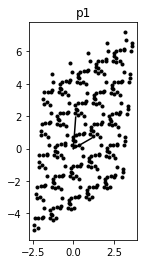

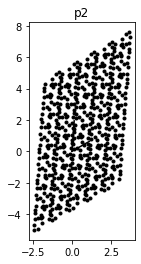

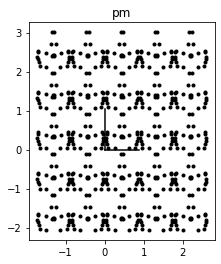

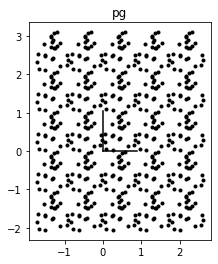

In [20]:
def plot_group(x, basis, g, title):    
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    plt.plot([0, basis[0,0]], [0,basis[0,1]], '-', color='black')
    plt.plot([0, basis[1,0]], [0,basis[1,1]], '-', color='black')
    n = [0, -1, 1, -2, 2]
    points = []
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis
            plt.plot(xc[:,0], xc[:,1], '.', color='black') #color=f'C{i}', alpha=1)
            points.append(xc[:2])
    x = np.vstack(points)
    #sns.kdeplot(x=x[:,0], y=x[:,1], shade=True, bw_adjust=0.2, cmap='Reds')
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.show()

np.random.seed(0)
npoints = 12
x = np.hstack((np.random.uniform(size=(npoints,2)) - 0.5, np.ones((npoints,1))))
basis = [[1,0], [0,1]] + np.random.uniform(size=(2,2))
for k,v in wallpaper.items():
    plot_group(x, basis, v, k)
plt.show()

In [15]:
with open('group.json', 'w') as f:
    #g = trans_2d(np.radians(90))
    #g = cgroup_2d(3)
    #g = sgroup_2d(2)
    #g = outer(sgroup_2d(4), cgroup_2d(3))
    g = outer(trans_2d(np.radians(60)), cgroup_2d(3))
    #g = trans_2d(np.radians(90)) + cgroup_2d(4)
    if not is_group(g, check_closed=False):
        print('Group is not closed!')
    write_group(f, g, 'C5')


0.0
2.0943951023931953
4.1887902047863905
Wrote group with 43 members and 8 tilings


In [253]:
Ntot = 500
Ns = Ntot // len(g)
N = int(np.floor(np.sqrt(Ns)))
Ns = N * N
Ntot = Ns * len(g)
box = 100
with open('start_positions.xyz', 'w') as f:
    p = np.linspace(box * 0.1, box * 0.9, N)
    for i in range(N):
        for j in range(N):
            #x = p[i] - box / 2 + (np.random.uniform() - 0.5) * box * 0.1
            #y = p[j] - box / 2 + (np.random.uniform() - 0.5) * box * 0.1
            x = np.random.uniform() * box
            y = np.random.uniform() * box
            f.write(f'{x} {y}\n')
    for i in range(Ntot - N):
        f.write('0.0 0.0\n')
print(Ns, Ntot, Ntot / len(g))



9 387 9.0


In [189]:
preamble_s = \
'''
#ifndef GEN_GROUPS_H_
#define GEN_GROUPS_H_

inline void mmult(double* dest, const double* m1, const double* m2, unsigned int n) {
    unsigned int i, j, k;
    memset(dest, n * n, sizeof(double));
    for(i = 0; i < n; i++)
        for(j = 0; j < n; j++)
            for(k = 0; k < n; k++)
                dest[i * n + j] += m1[i * n + k] * m2[k * n + j];
    
}
'''
post_s = '#endif // GEN_GROUPS_H_\n'

In [194]:
n = [-1, 0, 1]
list(itertools.product(n, repeat=3))

[(-1, -1, -1),
 (-1, -1, 0),
 (-1, -1, 1),
 (-1, 0, -1),
 (-1, 0, 0),
 (-1, 0, 1),
 (-1, 1, -1),
 (-1, 1, 0),
 (-1, 1, 1),
 (0, -1, -1),
 (0, -1, 0),
 (0, -1, 1),
 (0, 0, -1),
 (0, 0, 0),
 (0, 0, 1),
 (0, 1, -1),
 (0, 1, 0),
 (0, 1, 1),
 (1, -1, -1),
 (1, -1, 0),
 (1, -1, 1),
 (1, 0, -1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, -1),
 (1, 1, 0),
 (1, 1, 1)]

In [235]:
class Rhombus:
    def __init__(self, theta):
        self.theta = theta
    def ccode(n):
        m = np.eye(N + 1)
        m[:-1, :-1] = n * lattice  
        

def lattice_matrix(n, lattice, N):
    # each row of lattice should be a vector
    m = np.eye(N + 1)
    m[:-1, :-1] = n * lattice
    return m

def lattice_matrix_str(n, lattice, N):
    # each row of lattice should be a vector
    m = np.eye(N + 1)
    m[:-1, :-1] = n * lattice
    return m

def matrix_struct_init(m):
    return '{' + ','.join(m.flatten().astype(str)) + '}'
def gen_group(lattice, group):
    n = [-1, 0, 1]
    N = len(lattice[0])
    i = 0
    index = 0
    valid = []
    dgroup = []
    # see which ones are non-degenerate
    for g in group:
        for ns in itertools.product(n, repeat=N):
            m = lattice_matrix(ns, lattice, N)
            pg = m @ g
            if not in_group(pg, dgroup):
                dgroup.append(dg)
                valid.append(True)
            else:
                valid.append(False)
            pg = g @ m
            if not in_group(pg, dgroup):
                dgroup.append(dg)
                valid.append(True)
            else:
                valid.append(False)
    body = 'double m1[{N**2}], m2[{N**2}];'
    for g in group:
        for ns in itertools.product(n, repeat=N):
            if not valid[i]:
                i += 1                
                continue
            i += 1
            body += 'm1 = {",".join(g.flatten().astype(str)}'
            body += 'm2 = {",".join(g.flatten().astype(str)}'
            body += f'members[{index}] = '
    funct_s = \
f'''
g_t* create_group(double* vectors) {{
    g_t* members = malloc(sizeof(g_t) * {size});
    {body}
    return members;
}}
'''
    return funct_s


In [236]:
lattice_matrix_str([0,1], np.array([[0,1], [1,0]]), 2)

(3, 3)


'{0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0}'

In [232]:
[0,1] *  np.array([[0,1], [1,0]])

array([[0, 1],
       [0, 0]])